- <https://openpolicing.stanford.edu/data/>

# Imports

In [1]:
import datetime
import glob
import itertools
import json
import os
import pickle
import random
import re
from string import punctuation

In [2]:
import fuzzywuzzy
import geopandas as gpd
import humanize
import missingno as msno
import numpy as np
import pandas as pd
import recordlinkage
import scipy as sp
import statistics
import statsmodels.formula.api as smf
from pandas_profiling import ProfileReport

In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
MAPBOX_STYLE = "dark"
MAPBOX_HEIGHT = 800
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.ticker import PercentFormatter
px.set_mapbox_access_token(os.getenv("MAPBOX_PUBLIC_TOKEN_PERSONAL"))
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
plt.style.use("seaborn-colorblind")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Open Sans"
plt.rcParams["figure.figsize"] = 15, 6
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Functions

In [4]:
def zoom_center(
    lons: tuple = None,
    lats: tuple = None,
    lonlats: tuple = None,
    format: str = "lonlat",
    projection: str = "mercator",
    width_to_height: float = 2.0,
) -> (float, dict):
    """Finds optimal zoom and centering for a plotly mapbox.
    Must be passed (lons & lats) or lonlats.
    Temporary solution awaiting official implementation, see:
    https://github.com/plotly/plotly.js/issues/3434

    Parameters
    --------
    lons: tuple, optional, longitude component of each location
    lats: tuple, optional, latitude component of each location
    lonlats: tuple, optional, gps locations
    format: str, specifying the order of longitud and latitude dimensions,
        expected values: 'lonlat' or 'latlon', only used if passed lonlats
    projection: str, only accepting 'mercator' at the moment,
        raises `NotImplementedError` if other is passed
    width_to_height: float, expected ratio of final graph's with to height,
        used to select the constrained axis.

    Returns
    --------
    zoom: float, from 1 to 20
    center: dict, gps position with 'lon' and 'lat' keys

    >>> print(zoom_center((-109.031387, -103.385460),
    ...     (25.587101, 31.784620)))
    (5.75, {'lon': -106.208423, 'lat': 28.685861})
    """
    if lons is None and lats is None:
        if isinstance(lonlats, tuple):
            lons, lats = zip(*lonlats)
        else:
            raise ValueError("Must pass lons & lats or lonlats")

    maxlon, minlon = max(lons), min(lons)
    maxlat, minlat = max(lats), min(lats)
    center = {
        "lon": round((maxlon + minlon) / 2, 6),
        "lat": round((maxlat + minlat) / 2, 6),
    }

    # longitudinal range by zoom level (20 to 1)
    # in degrees, if centered at equator
    lon_zoom_range = np.array(
        [
            0.0007,
            0.0014,
            0.003,
            0.006,
            0.012,
            0.024,
            0.048,
            0.096,
            0.192,
            0.3712,
            0.768,
            1.536,
            3.072,
            6.144,
            11.8784,
            23.7568,
            47.5136,
            98.304,
            190.0544,
            360.0,
        ]
    )

    if projection == "mercator":
        margin = 1.2
        height = (maxlat - minlat) * margin * width_to_height
        width = (maxlon - minlon) * margin
        lon_zoom = np.interp(width, lon_zoom_range, range(20, 0, -1))
        lat_zoom = np.interp(height, lon_zoom_range, range(20, 0, -1))
        zoom = round(min(lon_zoom, lat_zoom), 2)
    else:
        raise NotImplementedError(f"{projection} projection is not implemented")

    return zoom, center

In [5]:
cache_dir = "cache"
os.makedirs(cache_dir, exist_ok=True)


def preprocess_data(
    data_file,
    mandatory_columns=None,
    categories_cnt=10,
    cache_dir=cache_dir,
    cache_file="preprocessed_data.pkl",
):
    """Convert each review to words; read from cache if available."""

    # If cache is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass

    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # load csv
        print("No cache data, reading raw data...")
        cache_data = pd.read_csv(data_file)

        # clean column names
        expression = "[^A-Za-z0-9]+"
        new_col_names = [
            re.sub(expression, "_", x).lower() for x in cache_data.columns
        ]
        cache_data.columns = new_col_names

        # cleanup data for needed cols missing data
        if mandatory_columns:
            cache_data.dropna(subset=mandatory_columns, inplace=True)

        # cleanup col types
        for col in cache_data.select_dtypes(include=['object']).columns:
            
            # get unique vals
            vals = cache_data[col].value_counts()
            
            # check for bool cols and cat cols
            if set(vals.index) == {True, False}:
                print(f"Fixing column {col} to be bool")
                cache_data[col] = cache_data[col].astype("bool")
            elif len(vals) < categories_cnt:
                print(f"Fixing column {col} to be category")
                cache_data[col].fillna("unspecified", inplace=True)
                cache_data[col] = cache_data[col].astype("category")
        
        # count pure duplicates
        if cache_data.duplicated().sum() > 0:
            cache_data.drop_duplicates(inplace=True)

        # date cols
        dt_cols = ['date', 'time']

        # add col indicating if time was NA for future filtering
        cache_data['time_unknown'] = cache_data.time.isnull()

        # replace unknown times with midnight
        cache_data['time'].fillna("00:00:00", inplace=True)

        # create a datetime col and set as index
        cache_data["datetime"] = pd.to_datetime(
            cache_data.date.str.cat(cache_data.time, sep=" "))
        cache_data.set_index("datetime", inplace=True)

        # drop the old time cols
        cache_data.drop(dt_cols, axis=1, inplace=True)

        # Write to cache file for future runs
        if cache_file is not None:
            print("Writing cache file...")
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)

    return cache_data

# Load Data

In [6]:
stop_df = preprocess_data('datasets/tn_nashville_2020_04_01.csv',
                          mandatory_columns=['subject_race', 'subject_sex'])

Read preprocessed data from cache file: preprocessed_data.pkl


In [7]:
# inspect
#profile = ProfileReport(stop_df)
#profile

# Data Types

In [8]:
stop_df.dtypes

raw_row_number                      object
location                            object
lat                                float64
lng                                float64
precinct                            object
reporting_area                     float64
zone                                object
subject_age                        float64
subject_race                      category
subject_sex                       category
officer_id_hash                     object
type                              category
violation                         category
arrest_made                           bool
citation_issued                       bool
warning_issued                        bool
outcome                           category
contraband_found                      bool
contraband_drugs                      bool
contraband_weapons                    bool
frisk_performed                       bool
search_conducted                      bool
search_person                         bool
search_vehi

# Data Ranges

# Categoricals

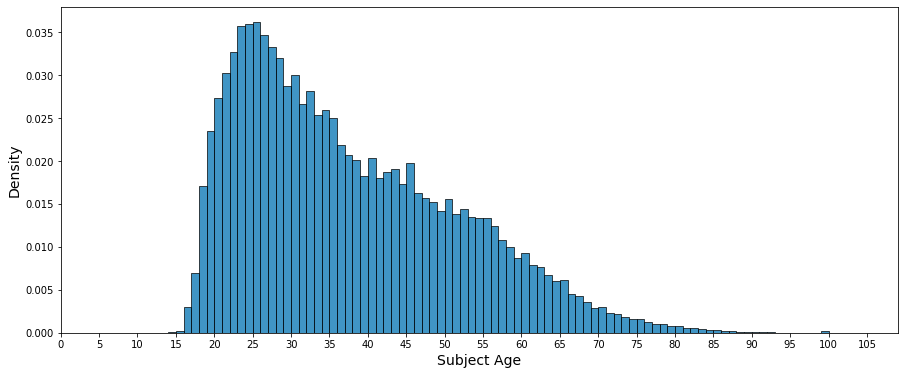

In [9]:
ages = stop_df.subject_age
xmin = 0
xmax = 110
bins = [x for x in np.arange(xmin, xmax, 1)]
fig, ax = plt.subplots()
sns.histplot(data=stop_df, x="subject_age", stat="density", common_norm=False, bins=bins, ax=ax)
ax.set_xlabel("Subject Age")
ax.set_xlim(bins[0], bins[-1]);
ticks = [x for x in np.arange(xmin, xmax, 5)]
ax.set_xticks(ticks);

In [10]:
stop_df.subject_age.describe()

count    3.077203e+06
mean     3.704964e+01
std      1.404364e+01
min      1.000000e+01
25%      2.600000e+01
50%      3.400000e+01
75%      4.700000e+01
max      9.900000e+01
Name: subject_age, dtype: float64

In [11]:
# categorical bins
bins = [x for x in np.arange(0, 110, 5)]
stop_df["age_bin"] = pd.cut(stop_df.subject_age, bins=bins)

In [12]:
stop_df.sample(5)

,raw_row_number,location,lat,lng,precinct,reporting_area,zone,subject_age,subject_race,subject_sex,...,raw_suspect_ethnicity,raw_driver_searched,raw_passenger_searched,raw_search_consent,raw_search_arrest,raw_search_warrant,raw_search_inventory,raw_search_plain_view,time_unknown,age_bin
datetime,,,,,,,,,,,,,,,,,,,,,
2011-08-12 21:32:00,554523,"FAIRFIELD AVE & LAFAYETTE ST, NASHVILLE, TN, 3...",36.147316,-86.757885,5.0,8221.0,511.0,18.0,black,female,...,N,False,False,False,False,False,False,False,False,"(15, 20]"
2012-01-05 06:13:00,1138968,"I 65 N & W TRINITY LN, NASHVILLE, TN, 37207",36.207045,-86.791595,2.0,1804.0,223.0,30.0,black,male,...,N,False,False,False,False,False,False,False,False,"(25, 30]"
2015-08-10 23:23:00,2211993,"17TH AVE N & WEST END AVE, NASHVILLE, TN, 37203",36.153794,-86.794395,8.0,5707.0,811.0,49.0,asian/pacific islander,female,...,N,False,False,False,False,False,False,False,False,"(45, 50]"
2014-08-07 09:24:00,1818013,"319 BONNARIDGE DR, HERMITAGE, TN, 37076",36.194882,-86.624644,5.0,9613.0,521.0,24.0,white,male,...,N,False,False,False,False,False,False,False,False,"(20, 25]"
2015-09-22 11:27:00,2251635,"HARDING PL & WAUFORD DR, NASHVILLE, , 37211",36.080944,-86.751596,NaN,NaN,NaN,31.0,hispanic,female,...,H,False,False,False,False,False,False,False,False,"(30, 35]"


In [13]:
# Count the number of missing values in each column
100 * (stop_df.isnull().sum() / len(stop_df)).sort_values(ascending=False)

notes                             83.451650
precinct                          12.595739
zone                              12.595739
reporting_area                    10.730066
lat                                6.034350
lng                                6.034350
vehicle_registration_state         1.008850
age_bin                            0.018195
subject_age                        0.018195
officer_id_hash                    0.000195
time_unknown                       0.000000
raw_search_plain_view              0.000000
raw_search_inventory               0.000000
reason_for_stop                    0.000000
raw_search_arrest                  0.000000
raw_search_consent                 0.000000
raw_passenger_searched             0.000000
raw_driver_searched                0.000000
raw_suspect_ethnicity              0.000000
raw_misd_state_citation_issued     0.000000
raw_traffic_citation_issued        0.000000
raw_written_warning_issued         0.000000
raw_verbal_warning_issued       

# Summaries

In [60]:
# is outcome one and only one per stop?
assert (pd.get_dummies(stop_df.outcome).sum(axis=1) > 1).sum() == 0, "outcome does not look exclusive"

In [117]:
stop_df.outcome.value_counts()

warning        2348253
citation        679167
arrest           50001
unspecified        342
Name: outcome, dtype: int64

In [15]:
stop_df.groupby(["subject_race", "subject_sex"]).warning_issued.mean()

subject_race            subject_sex
asian/pacific islander  female         0.813310
                        male           0.813720
black                   female         0.826990
                        male           0.817145
hispanic                female         0.755297
                        male           0.718216
other                   female         0.711280
                        male           0.697824
unknown                 female         0.699122
                        male           0.718054
white                   female         0.791935
                        male           0.783768
Name: warning_issued, dtype: float64

In [16]:
stop_df.groupby(["subject_race", "subject_sex"]).citation_issued.mean()

subject_race            subject_sex
asian/pacific islander  female         0.194395
                        male           0.193319
black                   female         0.202171
                        male           0.214036
hispanic                female         0.319980
                        male           0.367719
other                   female         0.296699
                        male           0.313057
unknown                 female         0.308908
                        male           0.289412
white                   female         0.218068
                        male           0.226069
Name: citation_issued, dtype: float64

In [17]:
stop_df.groupby(["subject_race", "subject_sex"]).arrest_made.mean()

subject_race            subject_sex
asian/pacific islander  female         0.003137
                        male           0.009385
black                   female         0.013645
                        male           0.029765
hispanic                female         0.013966
                        male           0.038193
other                   female         0.007980
                        male           0.009177
unknown                 female         0.003639
                        male           0.006003
white                   female         0.008376
                        male           0.012512
Name: arrest_made, dtype: float64

# Arrest Rates

In [183]:
# arrests
arrests = stop_df.arrest_made.resample('M').count().fillna(0).reset_index().set_index("datetime")

datetime
2010-01-31        NaN
2010-02-28    27001.0
2010-03-31    27704.0
2010-04-30    28934.5
2010-05-31    23814.0
               ...   
2018-11-30    12011.0
2018-12-31     7498.0
2019-01-31     5224.5
2019-02-28     5072.5
2019-03-31     4180.5
Freq: M, Name: arrest_made, Length: 111, dtype: float64

Text(0, 0.5, 'Total Arrests')

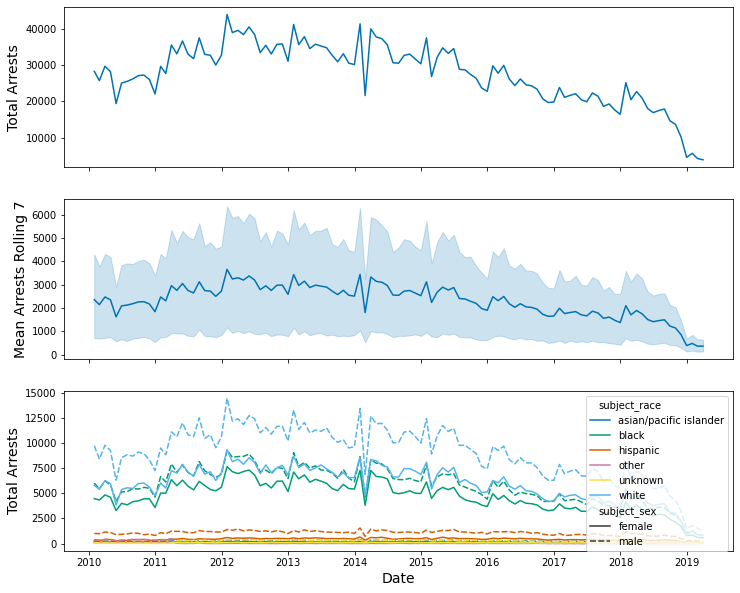

In [203]:
fig, ax = plt.subplots(3, 1, figsize=(12,10), sharex=True)

sns.lineplot(data=arrests, x="datetime", y="arrest_made", ax=ax[0])
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Total Arrests")

rolling = stop_df.arrest_made.resample('W').count().rolling(2).mean().fillna(
    0).reset_index().set_index("datetime")
sns.lineplot(data=bw,
             x="datetime",
             y="arrest_made",
             ax=ax[1])
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Mean Arrests Rolling 7")

bw = stop_df.groupby(["subject_race", "subject_sex"]).arrest_made.resample(
    'M').count().fillna(0).reset_index().set_index("datetime")
sns.lineplot(data=bw,
             x="datetime",
             y="arrest_made",
             hue="subject_race",
             style="subject_sex",
             ax=ax[2])
ax[2].set_xlabel("Date")
ax[2].set_ylabel("Total Arrests")




# Visualize on Map

In [189]:
MAPBOX_ZOOM, MAPBOX_CENTER = zoom_center(lons=[x for x in stop_df.lng if x],
                                         lats=[x for x in stop_df.lat if x])

In [190]:
N_PERCENT = 0.01
N_SAMPLES = round(N_PERCENT * len(stop_df))
print(f'Using {N_SAMPLES} samples')

Using 30778 samples


In [205]:
outfile = 'assets/stop_sample.png'
fig = px.density_mapbox(
    stop_df.sample(N_SAMPLES),
    lat='lat',
    lon='lng',
    radius=5,
    title="Sample of Police Stop|s",
    mapbox_style=MAPBOX_STYLE,
    height=MAPBOX_HEIGHT,
    center=MAPBOX_CENTER,
    zoom=MAPBOX_ZOOM,
)

fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
#fig.write_image(outfile, width=1200, height=800)
fig.show()